# Membuat Classifier nya

In [118]:
# !pip install tensorflow
# !pip install pillow

In [147]:
import tensorflow as tf

In [148]:
# Define Input Parameters
dim = (160, 160)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

# Membuat dataset generator

In [149]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data Generatornya

In [150]:
# train_datagen = ImageDataGenerator( rotation_range=30,          # Rotasi gambar hingga 30 derajat
#                                     width_shift_range=0.2,      # Pergeseran horizontal hingga 20%
#                                     height_shift_range=0.2,     # Pergeseran vertikal hingga 20%
#                                     shear_range=0.2,            # Distorsi shearing
#                                     zoom_range=0.2,             # Perbesar/perkecil hingga 20%
#                                     horizontal_flip=True,       # Membalikkan gambar secara horizontal
#                                     fill_mode='nearest'         # Mengisi piksel kosong setelah transformasi
#                                   )

# val_datagen = ImageDataGenerator( rotation_range=30,          # Rotasi gambar hingga 30 derajat
#                                     width_shift_range=0.2,      # Pergeseran horizontal hingga 20%
#                                     height_shift_range=0.2,     # Pergeseran vertikal hingga 20%
#                                     shear_range=0.2,            # Distorsi shearing
#                                     zoom_range=0.2,             # Perbesar/perkecil hingga 20%
#                                     horizontal_flip=True,       # Membalikkan gambar secara horizontal
#                                     fill_mode='nearest'         # Mengisi piksel kosong setelah transformasi
#                                   )

# test_datagen = ImageDataGenerator( rotation_range=30,          # Rotasi gambar hingga 30 derajat
#                                     width_shift_range=0.2,      # Pergeseran horizontal hingga 20%
#                                     height_shift_range=0.2,     # Pergeseran vertikal hingga 20%
#                                     shear_range=0.2,            # Distorsi shearing
#                                     zoom_range=0.2,             # Perbesar/perkecil hingga 20%
#                                     horizontal_flip=True,       # Membalikkan gambar secara horizontal
#                                     fill_mode='nearest'         # Mengisi piksel kosong setelah transformasi
#                                   )

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

## Mendefinisikan asal folder sumber file berasal

In [151]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('Dataset_polos_after/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('Dataset_polos_after/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('Dataset_polos_after/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 353 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


In [152]:
print(labels)

dict_keys(['Keriting', 'Kuning', 'Layu'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [153]:
import tensorflow as tf

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    # Mendefinisikan output_signature
    output_signature = (
        tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_class), dtype=tf.float32)
    )
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return tf_generator

In [154]:
# Menginisialisasi data generator
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

# Membuat Struktur CNN

## Manualy define network

In [155]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

In [156]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [157]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 160, 160, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 160, 160, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 158, 158, 32)        │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 158, 158, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 79, 79, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 79, 79, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 77, 77, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 77, 77, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 92416)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │      47,317,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 3)                   │           1,539 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,414,947 (180.87 MB)

 Trainable params: 47,414,947 (180.87 MB)

 Non-trainable params: 0 (0.00 B)

## Using Pre-trained model / Transfer Learning

### Build Base Model (MobileNetV2)

In [158]:
from tensorflow.keras.applications import MobileNetV2

# get base models
base_model = MobileNetV2(
    input_shape= input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

### Add top layer network

In [159]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [160]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [161]:
model.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 3,538,691 (13.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [162]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Effinet

In [163]:
!pip install -U --pre efficientnet

In [164]:
from efficientnet.tfkeras import EfficientNetB1

### Build Base model

In [165]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

### Add top network layer to models

In [166]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [167]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [168]:
model.summary()

Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)   │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 80, 80, 32)        │             864 │ input_layer_16[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 80, 80, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 80, 80, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 80, 80, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 80, 80, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 80, 80, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 80, 80, 32)        │               0 │ block1a_activation[0][0],  │
│                               │                           │                 │ block1a_se_expand[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 80, 80, 16)        │             512 │ block1a_se_excite[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 80, 80, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 7,890,051 (30.10 MB)

 Trainable params: 7,828,003 (29.86 MB)

 Non-trainable params: 62,048 (242.38 KB)

In [169]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Visualize The final model

In [170]:
import tensorflow as tf

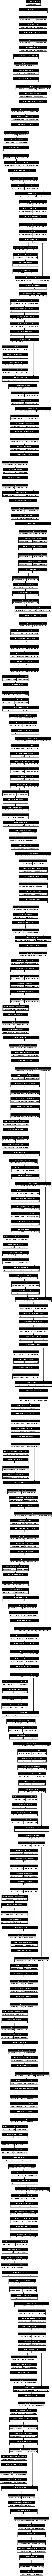

In [171]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

# Train Model

In [172]:
EPOCH = 10

In [173]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # Callback untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi loss
# early_stopping = EarlyStopping(
#     monitor='val_loss',      # Pantau validasi loss
#     patience=5,              # Berhenti jika tidak ada peningkatan selama 5 epoch
#     restore_best_weights=True  # Kembalikan bobot terbaik
# )

# # Callback untuk menurunkan learning rate secara dinamis
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',      # Pantau validasi loss
#     factor=0.2,              # Turunkan learning rate sebesar 20%
#     patience=3,              # Setelah 3 epoch tanpa peningkatan
#     min_lr=1e-6              # Learning rate minimum
# )

# # Callback untuk menyimpan model terbaik selama pelatihan
# model_checkpoint = ModelCheckpoint(
#     filepath='best_model.keras',  # Path untuk menyimpan model terbaik
#     monitor='val_loss',        # Pantau validasi loss
#     save_best_only=True,       # Hanya simpan jika model lebih baik
#     verbose=1
# )

# # Training dengan callbacks
# history = model.fit(
#     x=train_data,
#     steps_per_epoch=len(train_generator),
#     epochs=EPOCH,
#     validation_data=val_data,
#     validation_steps=len(val_generator),
#     shuffle=True,
#     verbose=1,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )


In [174]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8342 - loss: 0.4509 - val_accuracy: 0.9111 - val_loss: 0.5077
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9944 - loss: 0.0158 - val_accuracy: 0.6889 - val_loss: 2.6824
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9806 - loss: 0.0492 - val_accuracy: 0.6667 - val_loss: 0.6210
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9875 - loss: 0.0443 - val_accuracy: 0.9333 - val_loss: 0.1489
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9810 - loss: 0.0869 - val_accuracy: 0.8000 - val_loss: 0.4890
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9986 - loss: 0.0127 - val_accuracy: 0.6000 - val_loss: 1.9368
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9947 - loss: 0.0372 - val_accuracy: 0.8889 - val_loss: 0.2377
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9984 - loss: 0.0106 - val_accuracy: 0.8667 - val_loss

In [175]:
history.history['loss']

[0.20905807614326477,
 0.04914913699030876,
 0.07295900583267212,
 0.043571148067712784,
 0.077174112200737,
 0.02731461077928543,
 0.04737561196088791,
 0.022036511451005936,
 0.007317918352782726,
 0.03611132502555847]

In [176]:
history.history['accuracy']

[0.9348441958427429,
 0.9830028414726257,
 0.9716714024543762,
 0.9886685609817505,
 0.980169951915741,
 0.9943342804908752,
 0.9915013909339905,
 0.9943342804908752,
 0.9971671104431152,
 0.9858356714248657]

# Plot the training

In [177]:
from matplotlib import pyplot as plt

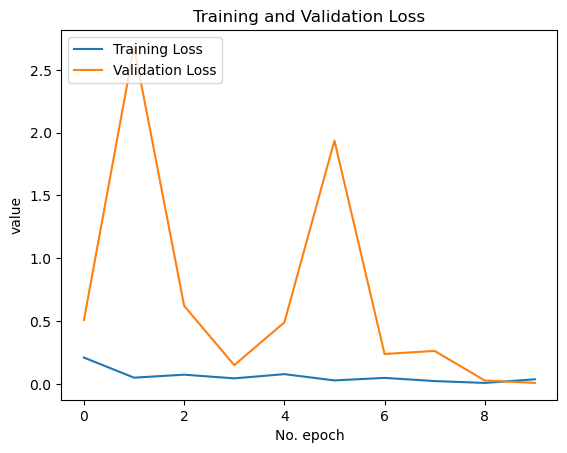

In [178]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

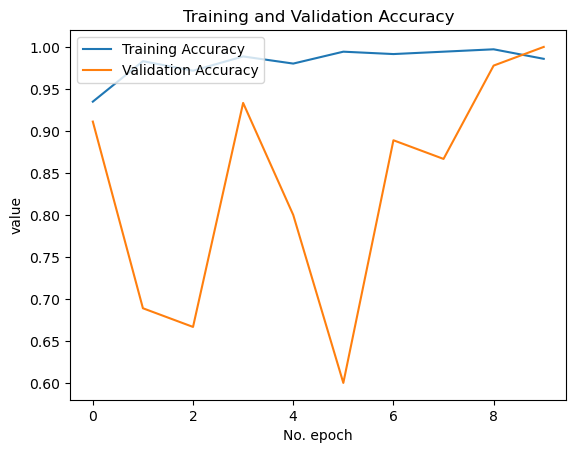

In [179]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [180]:
import os

In [181]:
# MODEL_BASE_PATH = "model"
# PROJECT_NAME = "medium_project"
# SAVE_MODEL_NAME = "model_medium.h5"
# save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

# if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
#     os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
# print('Saving Model At {}...'.format(save_model_path))
# model.save(save_model_path,include_optimizer=False)    

import os
import tensorflow as tf

MODEL_BASE_PATH = "model"
PROJECT_NAME = "Cabe"
SAVE_MODEL_NAME = "model_cabe.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

# Cek dan buat folder jika belum ada
if not os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)):
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
# Menyimpan model dalam format .h5
print('Saving Model in .h5 format at {}...'.format(save_model_path))
model.save(save_model_path, include_optimizer=False)    

# Konversi model ke format .tflite
print('Converting and Saving Model in .tflite format...')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: tambahkan optimasi kuantisasi jika dibutuhkan
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Mengurangi ukuran model dan meningkatkan performa
tflite_model = converter.convert()

# Menyimpan model dalam format .tflite
save_tflite_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "model_cabe.tflite")
with open(save_tflite_path, 'wb') as f:
    f.write(tflite_model)

print('Model saved in .tflite format at {}...'.format(save_tflite_path))

    

Saving Model in .h5 format at model\Cabe\model_cabe.h5...
Converting and Saving Model in .tflite format...
INFO:tensorflow:Assets written to: C:\Users\VERIMA~1\AppData\Local\Temp\tmp6ttzyykh\assets


INFO:tensorflow:Assets written to: C:\Users\VERIMA~1\AppData\Local\Temp\tmp6ttzyykh\assets


Saved artifact at 'C:\Users\VERIMA~1\AppData\Local\Temp\tmp6ttzyykh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_3324')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2448976887248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285607248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285608976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2448976886864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2448976886672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285609360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285611856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285611664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285607440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2451285611472: TensorSpec(shape=(), dtype=tf.resource, name=None)

# Evaluate Models

In [182]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.9802 
Loss on training data: 0.0881 

Accuracy on test data: 0.9773 
Loss on test data: 0.0820 



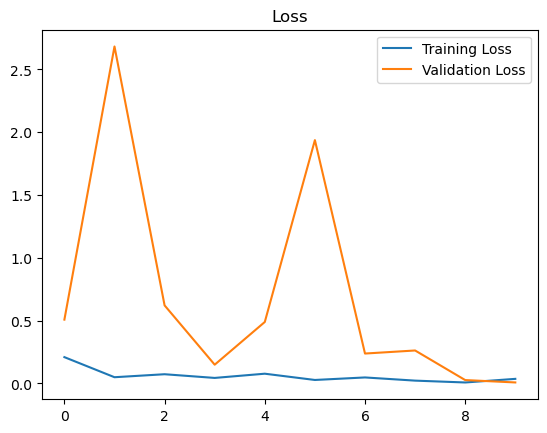

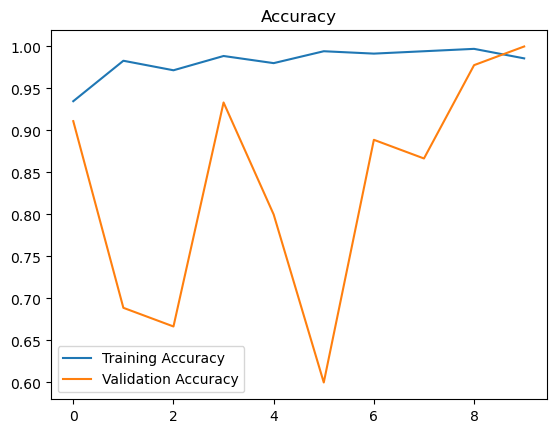

In [183]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
